In [3]:
import os
import glob
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# Preapre dataset (lazy-read)


In [5]:
import tensorflow as tf
import pathlib

ROOT = '/content/drive/My Drive/Colab Notebooks/Carvana_UNet'
TRAIN_DIR = 'train'
MASK_DIR = 'train_masks'

tf_dataset = tf.data.Dataset.list_files(os.path.join(ROOT, TRAIN_DIR, '*.*'),
                                        shuffle=True)

In [ ]:
FULL_TRAIN_SIZE = len(tf_dataset)
TRAIN_RATIO = 0.8
TRAIN_SIZE = int(FULL_TRAIN_SIZE * TRAIN_RATIO)
VAL_SIZE = FULL_TRAIN_SIZE - TRAIN_SIZE

train_ds = tf_dataset.take(TRAIN_SIZE)
val_ds = tf_dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
print(f'training size: {len(train_ds)}, validation size: {len(val_ds)}')

training size: 4070, validation size: 1018


In [ ]:
IMG_HEIGHT = 320
IMG_WIDTH = 480
IMG_CHANNELS = 3

def find_stem(file_path) -> str:
  stem = tf.strings.split(file_path, os.sep)[-1]
  stem = stem.numpy().decode('utf-8')
  return pathlib.Path(stem).stem

def decode_resize_img(img):
  img = tf.io.decode_image(img, channels=IMG_CHANNELS)
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def decode_resize_gif(img):
  img = tf.io.decode_image(img, channels=IMG_CHANNELS,
                           expand_animations=False)
  img = img[:,:,0:1]
  img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
  return img / 255

# Output has image with shape [h, w, channel],
# and mask of shape [h, w, 1], with channel values between [0, 1]
def load_img_and_mask(file_path) -> (tf.float32, tf.float32):
  stem = find_stem(file_path)
  mask_file = str(pathlib.Path(ROOT, MASK_DIR, stem + '_mask.gif'))
  mask_file = tf.convert_to_tensor(mask_file, dtype=tf.string)
  img = tf.io.read_file(file_path)
  img = decode_resize_img(img)
  mask = tf.io.read_file(mask_file)
  mask = decode_resize_gif(mask)

  return img, mask


train_ds = train_ds.map(lambda x: tf.py_function(func=load_img_and_mask,
                                  inp=[x],
                                  Tout=(tf.float32, tf.float32)),
                                  num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x: tf.py_function(func=load_img_and_mask,
                              inp=[x],
                              Tout=(tf.float32, tf.float32)),
                              num_parallel_calls=tf.data.AUTOTUNE)

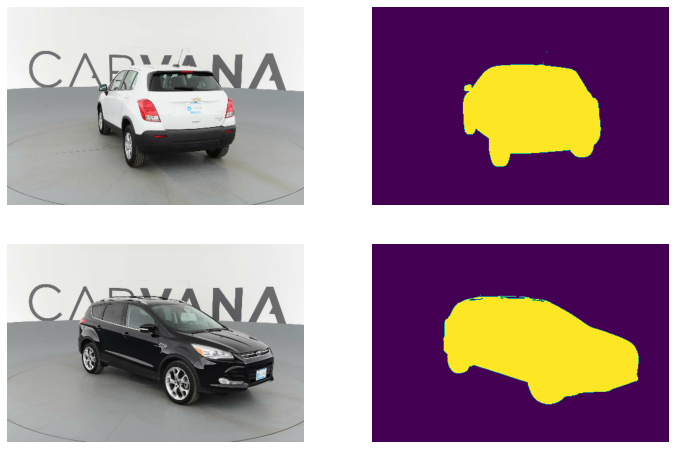

In [ ]:
plt.figure(figsize=(12, 8))
for i, (img, mask) in enumerate(train_ds.take(2)):
  ax = plt.subplot(2, 2, i*2+1)
  plt.imshow(img.numpy().astype('uint8'))
  plt.axis("off")
  ax = plt.subplot(2, 2, i*2+2)
  plt.imshow(mask.numpy().astype('uint8').squeeze(axis=2))
  plt.axis("off")

In [ ]:
BATCH_SIZE = 16
def configure_for_performance(ds):
  #ds = ds.cache()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

#Create a UNet Model

![](https://drive.google.com/uc?id=1tRvTdQ5eTAl-0vZz2Q4TUs8L2LmRt6pt)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPooling2D, concatenate

In [ ]:
def shape(layer):
  print(layer + f': {eval(layer).shape}')

'''
Crop larger tensor to align with the smaller one
'''
def crop_and_concatinate(first, second):
  diff_h = first.shape[1] - second.shape[1]
  diff_w = first.shape[2] - second.shape[2]

  crop_fir_h = max(0, diff_h)
  crop_fir_w = max(0, diff_w)

  crop_sec_h = min(0, diff_h)
  crop_sec_w = min(0, diff_w)

  first = tf.keras.layers.Cropping2D(cropping=((0, crop_fir_h), (0, crop_fir_w)))(first)
  second = tf.keras.layers.Cropping2D(cropping=((0, crop_sec_h), (0, crop_sec_w)))(second)
  return concatenate([first, second], axis=3)

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)

c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2), padding='same') (c1)
shape('c1')
shape('p1')
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2), padding='same') (c2)
shape('c2')
shape('p2')
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2), padding='same') (c3)
shape('c3')
shape('p3')
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2), padding='same') (c4)
shape('c4')
shape('p4')
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)
shape('c5')
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
shape('u6')
u6 = crop_and_concatinate(u6, c4)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)
shape('c6')
shape('u6')
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = crop_and_concatinate(u7, c3)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)
shape('u7')
shape('c7')
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2)) (c7)
shape('u8')
u8 = crop_and_concatinate(u8, c2)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)
shape('u8')
shape('c8')
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = crop_and_concatinate(u9, c1)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)
shape('u9')
shape('c9')
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
# outputs = np.where(output >= 0.5, 1, 0)

c1: (None, 320, 480, 32)
p1: (None, 160, 240, 32)
c2: (None, 160, 240, 64)
p2: (None, 80, 120, 64)
c3: (None, 80, 120, 128)
p3: (None, 40, 60, 128)
c4: (None, 40, 60, 256)
p4: (None, 20, 30, 256)
c5: (None, 20, 30, 512)
u6: (None, 40, 60, 128)
c6: (None, 40, 60, 256)
u6: (None, 40, 60, 384)
u7: (None, 80, 120, 192)
c7: (None, 80, 120, 128)
u8: (None, 160, 240, 32)
u8: (None, 160, 240, 96)
c8: (None, 160, 240, 64)
u9: (None, 320, 480, 48)
c9: (None, 320, 480, 32)


In [ ]:
from tensorflow.keras.models import Model

def dice_loss(y_true, y_pred):
    res = 0
    batch_size = y_true.shape[0]
    for batch in range(batch_size):
        true_slice = y_true[batch]
        pred_slice = y_pred[batch]
        #pred_slice = tf.where(pred_slice >= 0.5, 1.0, 0.0) # not differentiable
        numerator = tf.reduce_sum(true_slice * pred_slice) * 2
        denominator = tf.reduce_sum(true_slice + pred_slice)
        res = (numerator/denominator) + res
    res = res / batch_size
    return tf.constant(1.0) - res

model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['BinaryAccuracy'])
model.compile(optimizer='adam', loss=dice_loss, metrics=['BinaryAccuracy'], run_eagerly=True)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 480, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 320, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 480, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 480, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
!nvidia-smi

Fri Mar 12 08:45:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    288MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Untrained model prediction

1/1 [==============================] - 1s 593ms/step


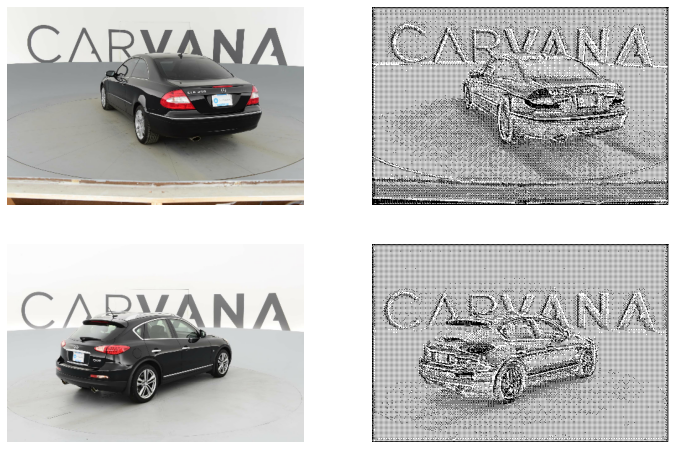

In [ ]:
import numpy as np

sample_size = 2
for xs_ys in train_ds.take(1):
  x_train = xs_ys[0]
  fig = plt.figure(figsize=(12, 4*sample_size))
  for i in range(sample_size):
    img = x_train[i:i+1]
    pred = model.predict(img, verbose=1)
    pred_img = np.where(pred[0] >= 0.5, 255, 0)
    pred_img = np.repeat(pred_img, 3, axis=2)

    ax = plt.subplot(sample_size, 2, i*2+1)
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.axis("off")
    ax = plt.subplot(sample_size, 2, i*2+2)
    plt.imshow(pred_img)
    plt.axis("off")

# Model training

In [ ]:
import csv
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow import keras

EPOCHS = 50
PATIENCE = 15

model_directory= ROOT + '/' # directory to save model history after every epoch 

class StoreModelHistory(keras.callbacks.Callback):

  def on_epoch_end(self,batch,logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr',0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    if not ('model_history.csv' in os.listdir(model_directory)):
      with open(model_directory+'model_history.csv','a') as f:
        y=csv.DictWriter(f,logs.keys())
        y.writeheader()

    with open(model_directory+'model_history.csv','a') as f:
      y=csv.DictWriter(f,logs.keys())
      y.writerow(logs)

earlystopper = EarlyStopping(patience=PATIENCE, verbose=1)
checkpointer = ModelCheckpoint(os.path.join(ROOT, 'model_unet_with_tf_datatset_checkpoint.h5'), verbose=1, save_best_only=True)
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[earlystopper, checkpointer, StoreModelHistory()])

Epoch 1/50
255/255 [==============================] - 1708s 7s/step - loss: 0.1685 - binary_accuracy: 0.9301 - val_loss: 0.5469 - val_binary_accuracy: 0.8552

Epoch 00001: val_loss improved from inf to 0.54689, saving model to /content/drive/My Drive/Colab Notebooks/Carvana_UNet/model_unet_with_tf_datatset_checkpoint.h5
Epoch 2/50
255/255 [==============================] - 610s 2s/step - loss: 0.0160 - binary_accuracy: 0.9934 - val_loss: 0.0319 - val_binary_accuracy: 0.9862

Epoch 00002: val_loss improved from 0.54689 to 0.03191, saving model to /content/drive/My Drive/Colab Notebooks/Carvana_UNet/model_unet_with_tf_datatset_checkpoint.h5
Epoch 3/50
255/255 [==============================] - 475s 2s/step - loss: 0.0115 - binary_accuracy: 0.9946 - val_loss: 0.1951 - val_binary_accuracy: 0.8945

Epoch 00003: val_loss did not improve from 0.03191
Epoch 4/50
255/255 [==============================] - 455s 2s/step - loss: 0.0119 - binary_accuracy: 0.9943 - val_loss: 0.0091 - val_binary_accu

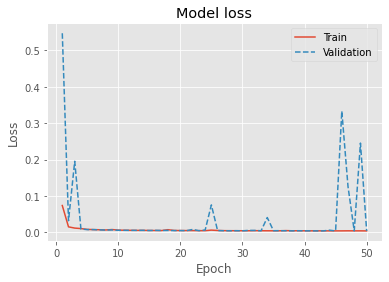

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
model_directory= ROOT + '/'
EPOCHS = 50

history_dataframe = pd.read_csv(model_directory+'model_history.csv',sep=',')

# Plot training & validation loss values
plt.style.use("ggplot")
plt.plot(range(1,EPOCHS+1),
         history_dataframe['loss'])
plt.plot(range(1,EPOCHS+1),
         history_dataframe['val_loss'],
         linestyle='--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Predict test set

In [ ]:
import numpy as np
from PIL import Image

TEST_ROOT = 'test_16'

_,_,pred_files = next(os.walk(os.path.join(ROOT, TEST_ROOT)))
X_test = np.zeros((len(pred_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for i, img_path in enumerate(pred_files): 
  img = Image.open(os.path.join(ROOT, TEST_ROOT, img_path))
  img = img.resize((IMG_WIDTH, IMG_HEIGHT))
  img_arr = np.asarray(img)
  X_test[i] = img_arr

#X_test = tf.convert_to_tensor(X_test, dtype=tf.uint8)
X_test.shape

(16, 320, 480, 3)

In [ ]:
import keras

model_path = os.path.join(ROOT, 'model_unet_with_tf_datatset_checkpoint.h5')
model = keras.models.load_model(model_path, compile=False)
Y_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 7s 7s/step


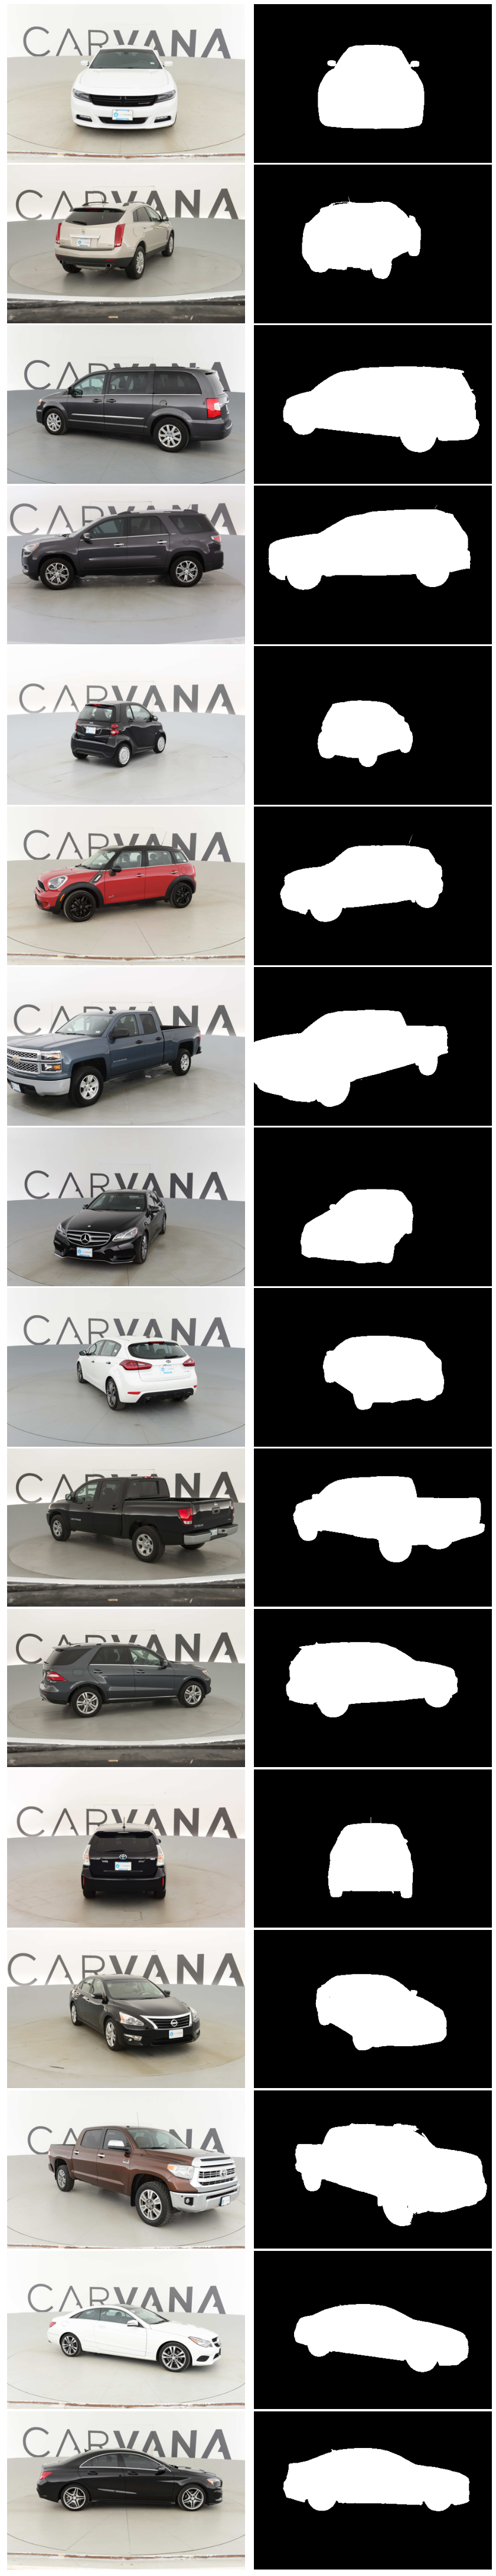

In [ ]:
pred_mask = np.where(Y_test >= 0.5, 255, 0)
pred_mask = np.repeat(pred_mask, 3, axis=3)

ROWS = Y_test.shape[0]
fig = plt.figure(figsize=(15, 5 * ROWS))
fig.subplots_adjust(wspace=0, hspace=0.01)
for i, (img, mask) in enumerate(zip(X_test, pred_mask)):
  plt.subplot(ROWS, 2, 2*i+1)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.subplot(ROWS, 2, 2*i+2)
  plt.imshow(mask)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
plt.show()